# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow==2.3.0 -q

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.3.0


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.15.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 50

# Data Loading

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/SDGP P2/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/SDGP P2/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

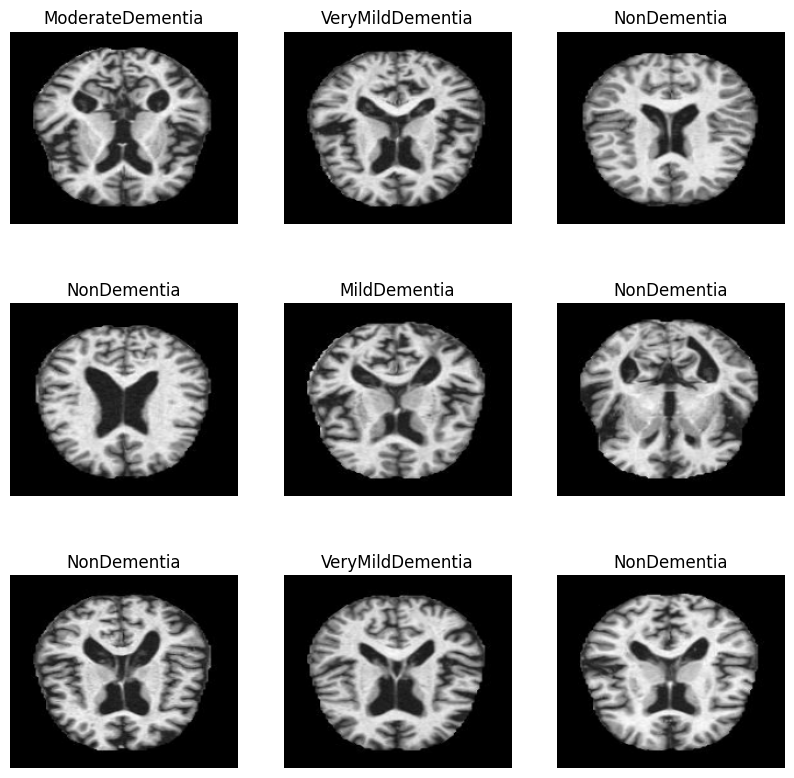

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/SDGP P2/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
NUM_IMAGES

[717, 52, 2560, 1792]

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]

    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

Let's fit our model!

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/50
257/257 [==============================] - 396s 2s/step - loss: 1.1177 - auc: 0.7755 - val_loss: 1.2103 - val_auc: 0.8055 - lr: 0.0100
Epoch 2/50
257/257 [==============================] - 340s 1s/step - loss: 0.9746 - auc: 0.8135 - val_loss: 1.2192 - val_auc: 0.6207 - lr: 0.0089
Epoch 3/50
257/257 [==============================] - 358s 1s/step - loss: 0.9531 - auc: 0.8202 - val_loss: 10.3304 - val_auc: 0.6634 - lr: 0.0079
Epoch 4/50
257/257 [==============================] - 338s 1s/step - loss: 0.9411 - auc: 0.8252 - val_loss: 16.1126 - val_auc: 0.6731 - lr: 0.0071
Epoch 5/50
257/257 [==============================] - 340s 1s/step - loss: 0.9141 - auc: 0.8358 - val_loss: 1.9547 - val_auc: 0.7929 - lr: 0.0063
Epoch 6/50
257/257 [==============================] - 339s 1s/step - loss: 0.9086 - auc: 0.8398 - val_loss: 1.0081 - val_auc: 0.7883 - lr: 0.0056
Epoch 7/50
257/257 [==============================] - 337s 1s/step - loss: 0.9183 - auc: 0.8346 - val_loss: 2.6863 - val_a

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

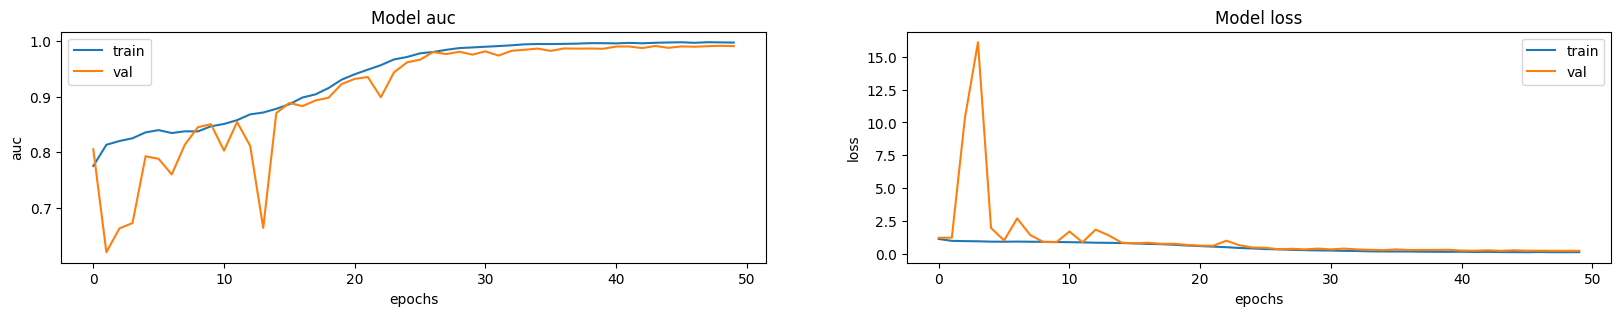

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/SDGP P2/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
_ = model.evaluate(test_ds)

80/80 [==============================] - 66s 671ms/step - loss: 1.3766 - auc: 0.8622


In [ ]:
# Save the model
model.save("/path/to/my_model.hdf5")

**Testing the Model**

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("/content/alzheimer_model.h5")

In [ ]:
# Load a test image
test_image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/SDGP P2/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg", target_size=(176, 208))

In [ ]:
# Preprocess the image
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

In [ ]:
# Make predictions
predictions = model.predict(test_image)

1/1 [==============================] - 0s 374ms/step


In [ ]:
# Get the predicted class label
predicted_class = class_names[np.argmax(predictions)]

In [ ]:
# Print the predicted class
print("Predicted Class:", predicted_class)

Predicted Class: VeryMildDementia
